In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(precision = 3, suppress = True)

### Параметри для генерування часового ряду або читання даних з файлів

In [2]:
READ_FROM_FILE = False

if READ_FROM_FILE:
    a, b = [], []
    with open('./test.txt') as fin:
        for line in fin:
            coef = line.strip().split('=')
            if coef[0].startswith('a'):
                a.append(float(coef[1]))
            if coef[0].startswith('b'):
                b.append(float(coef[1]))
    y = pd.Series(np.loadtxt('./y.txt'))
    v = np.loadtxt('./v.txt')
    v = pd.Series(v, index=pd.RangeIndex(len(y)-len(v), len(y)))
    gen_order = (len(a), len(b))
    N = len(y)
else:
    gen_order = (3, 3)          # порядок моделі
    a = [0, 0.22, -0.18, 0.08]  # коефіцієнти АР
    b = [0.5, 0.25, 0.25]       # коефіцієнти КС
    N = 100                     # кількість згенерованих значень

### Функція для генерування часового ряду

In [3]:
def make_series(a_coef, b_coef, order, n, mov_avg = None, noise_std = 0, coef=1):
    if mov_avg is None:
        mov_avg = pd.Series(
            np.random.randn(n+max(order)),
            pd.RangeIndex(-max(order), n)
            )
        RETURN_MA = True
    else:
        RETURN_MA = False
        
    y = pd.Series(
            np.concatenate([mov_avg.loc[-order[0]:-1], a_coef[0]*np.ones(n)]),
            pd.RangeIndex(-order[0], n)
            )
    
    a_c = list(reversed(a_coef[1:]))
    b_c = list(reversed(b_coef))
    
    for k in range(n):
        y[k] += (
            (y.loc[k-order[0]:k-1]*a_c).sum() #y(k-1) ... y(k-order[0])
            + coef*mov_avg.loc[k]
            + (mov_avg.loc[k-order[1]:k-1]*b_c).sum() 
            + np.random.randn()*noise_std
            )
    if RETURN_MA:
        return y.loc[0:], mov_avg
    else:
        return y.loc[0:]

### Власне генерування часового ряду та його візуалізація

In [4]:
if not READ_FROM_FILE: 
    np.random.seed(42)
    y, v = make_series(a_coef = a, b_coef = b, 
                       order = gen_order, n = N,
                       noise_std = 0.5)

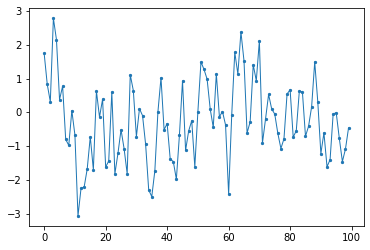

In [5]:
plt.plot(y, lw = 1)
plt.scatter(np.arange(N), y, s = 5)

### Функція для створення матриці спостережень X

In [6]:
def create_X(y, v, order = (3, 3)):
    N = min(len(y.loc[0:])-order[0]-1, len(v.loc[0:])-order[1]-1)
    m = max(order)
    X = np.zeros((N, 2+order[0]+order[1]))
    X[:, 0] = np.ones((N, ))
    
    for j in range(1, order[0]+1):
        X[:, j] = y.loc[m-j:m-j +N-1] 
    for j in range(order[1]+1):
        X[:, order[0]+1+j] = v.loc[m-j:m-j+N-1]
    return X, y.loc[m:m+N-1].to_numpy()

### МНК

In [7]:
def LS(X, y):
    coefs_history = []
    for i in range(len(y)):
        X_temp = X[:i+1]
        y_temp = y[:i+1]
        coefs_history.append(
            np.linalg.pinv(X_temp.T @ X_temp) @ X_temp.T @ y_temp
        )
    return coefs_history

### РМНК

In [8]:
def RLS(X, y):
    n = X.shape[1]
    theta = np.zeros((n, 1))
    coefs_history = []
    P = 100 * np.eye(n)
    for i in range(len(y)):
        x = X[i].reshape((n, 1))
        temp = P @ x / (1 + x.T @ P @ x)
        theta += temp * (y[i] - x.T @ theta)
        coefs_history.append(theta.flatten())
        P = P - temp @ x.T @ P
    return coefs_history

### Функції для обчислення метрик моделі

In [9]:
# сума квадратів похибок
def sum_squared_error(y_true, y_pred):
    return ((y_true - y_pred)**2).sum()

# коефіцієнт детермінації R^2
def r_squared(y_true, y_pred):
    return y_pred.var()/y_true.var()

# значення критерію Акайке
def akaike(y_true, y_pred, ARMA):
    n = ARMA[0] + ARMA[1] +1
    N = y_true.size 
    return N * np.log(sum_squared_error(y_true,y_pred)) + 2*n

### Задання порядку моделі, яка буде шукатися

In [10]:
ARMA = (3, 3)

### Створення матриці X та вигляд її перших 5 рядків

In [11]:
X, y_k = create_X(y, v, ARMA)
X[:5]

array([[ 1.   ,  0.314,  0.83 ,  1.742,  1.579, -0.234, -0.234,  1.523],
       [ 1.   ,  2.787,  0.314,  0.83 ,  0.767,  1.579, -0.234, -0.234],
       [ 1.   ,  2.15 ,  2.787,  0.314, -0.469,  0.767,  1.579, -0.234],
       [ 1.   ,  0.376,  2.15 ,  2.787,  0.543, -0.469,  0.767,  1.579],
       [ 1.   ,  0.776,  0.376,  2.15 , -0.463,  0.543, -0.469,  0.767]])

### Знаходження коефіцієнтів за допомогою МНК та їх оцінювання

In [12]:
LS_history = LS(X, y_k)
res_LS = LS_history[-1]
print(res_LS)

[ 0.03   0.124 -0.208  0.142  0.932  0.58   0.397  0.225]


In [13]:
y_LS = make_series(a_coef = res_LS[:ARMA[0]+1], b_coef = res_LS[ARMA[0]+2:], 
                order = ARMA, n = N, mov_avg = v, coef=res_LS[ARMA[0]+1])

In [14]:
print('S =', sum_squared_error(y, y_LS))
print('R^2 =', r_squared(y, y_LS))
print('IKA =', akaike(y, y_LS, ARMA))

S = 22.24898907198232
R^2 = 0.8524492707868712
IKA = 324.2296572612963


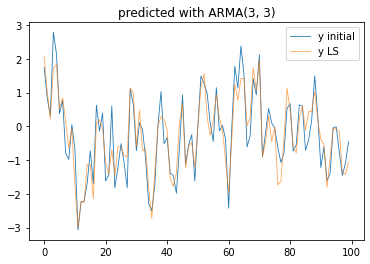

In [15]:
plt.plot(y, label = 'y initial', lw = 0.8)
plt.plot(y_LS, label = 'y LS', lw = 0.8, alpha = 0.7)
plt.title('predicted with ARMA' + f'{ARMA}')
plt.legend()

### Знаходження коефіцієнтів за допомогою РМНК та їх оцінювання

In [16]:
RLS_history = RLS(X, y_k)
res_RLS = RLS_history[-1]
print(res_RLS)

[ 0.03   0.124 -0.208  0.142  0.932  0.58   0.397  0.225]


In [17]:
y_RLS = make_series(a_coef = res_RLS[:ARMA[0]+1], b_coef = res_RLS[ARMA[0]+2:], 
                order = ARMA, n = N, mov_avg = v, coef=res_RLS[ARMA[0]+1])

In [18]:
print('S =', sum_squared_error(y, y_RLS))
print('R^2 =', r_squared(y, y_RLS))
print('IKA =', akaike(y, y_RLS, ARMA))

S = 22.248452438599546
R^2 = 0.8522420754494754
IKA = 324.2272452871936


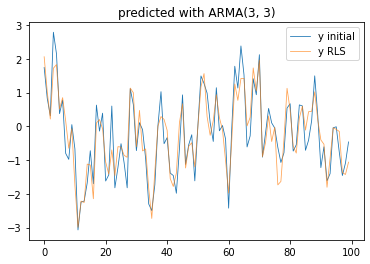

In [19]:
plt.plot(y, label = 'y initial', lw = 0.8)
plt.plot(y_RLS, label = 'y RLS', lw = 0.8, alpha = 0.7)
plt.title('predicted with ARMA' + f'{ARMA}')
plt.legend()

---

### Тестуємо всі потрібні порядки АРКС

In [20]:
import itertools
for ARMA in itertools.product([1,2,3], repeat=2):
    X, y_k = create_X(y, v, ARMA)
    
    LS_history = LS(X, y_k)
    res_LS = LS_history[-1]
    #res_LS[ARMA[0]+1] = 1
    y_LS = make_series(a_coef = res_LS[:ARMA[0]+1], b_coef = res_LS[ARMA[0]+2:], 
                order = ARMA, n = N, mov_avg = v, coef=res_LS[ARMA[0]+1])
    RLS_history = RLS(X, y_k)
    res_RLS = RLS_history[-1]
    #res_RLS[ARMA[0]+1] = 1
    y_RLS = make_series(a_coef = res_RLS[:ARMA[0]+1], b_coef = res_RLS[ARMA[0]+2:], 
                order = ARMA, n = N, mov_avg = v, coef=res_RLS[ARMA[0]+1])
    print(f'--- ARMA{ARMA}, LS ---')
    print(f'S = {sum_squared_error(y, y_LS):.3f}')
    print(f'R^2 = {r_squared(y, y_LS):.3f}')
    print(f'IKA = {akaike(y, y_LS, ARMA):.3f}')
    print(f'--- ARMA{ARMA}, RLS ---')
    print(f'S = {sum_squared_error(y, y_RLS):.3f}')
    print(f'R^2 = {r_squared(y, y_RLS):.3f}')
    print(f'IKA = {akaike(y, y_RLS, ARMA):.3f}')
    print('\n')

--- ARMA(1, 1), LS ---
S = 24.972
R^2 = 0.831
IKA = 327.774
--- ARMA(1, 1), RLS ---
S = 24.972
R^2 = 0.831
IKA = 327.774


--- ARMA(1, 2), LS ---
S = 25.114
R^2 = 0.838
IKA = 330.343
--- ARMA(1, 2), RLS ---
S = 25.113
R^2 = 0.838
IKA = 330.340


--- ARMA(1, 3), LS ---
S = 22.686
R^2 = 0.858
IKA = 322.173
--- ARMA(1, 3), RLS ---
S = 22.684
R^2 = 0.858
IKA = 322.168


--- ARMA(2, 1), LS ---
S = 23.454
R^2 = 0.836
IKA = 323.504
--- ARMA(2, 1), RLS ---
S = 23.454
R^2 = 0.836
IKA = 323.505


--- ARMA(2, 2), LS ---
S = 23.735
R^2 = 0.838
IKA = 326.696
--- ARMA(2, 2), RLS ---
S = 23.735
R^2 = 0.837
IKA = 326.695


--- ARMA(2, 3), LS ---
S = 22.913
R^2 = 0.860
IKA = 325.168
--- ARMA(2, 3), RLS ---
S = 22.911
R^2 = 0.860
IKA = 325.161


--- ARMA(3, 1), LS ---
S = 23.274
R^2 = 0.835
IKA = 324.733
--- ARMA(3, 1), RLS ---
S = 23.274
R^2 = 0.835
IKA = 324.733


--- ARMA(3, 2), LS ---
S = 23.276
R^2 = 0.836
IKA = 326.744
--- ARMA(3, 2), RLS ---
S = 23.276
R^2 = 0.835
IKA = 326.743


--- ARMA(3, 3), 

In [21]:
LS_history = np.array(LS_history)
RLS_history = np.array(RLS_history)

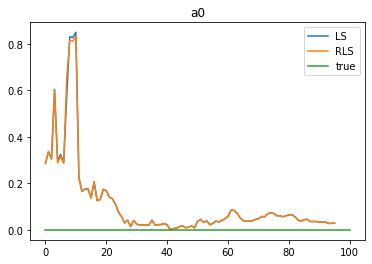

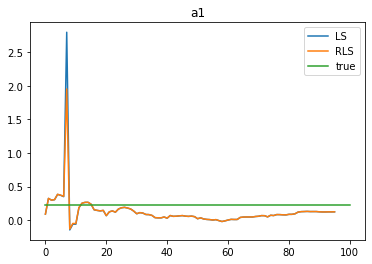

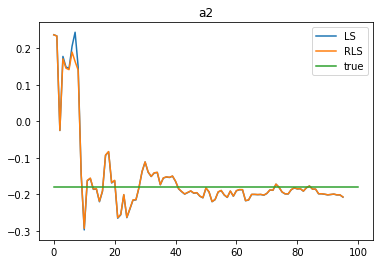

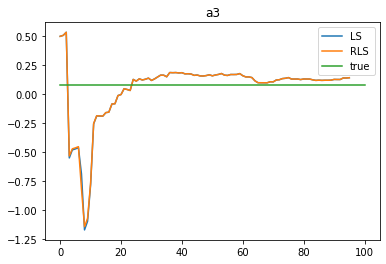

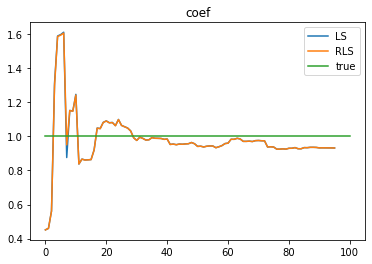

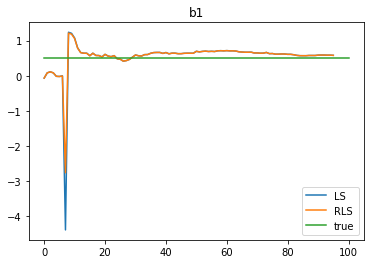

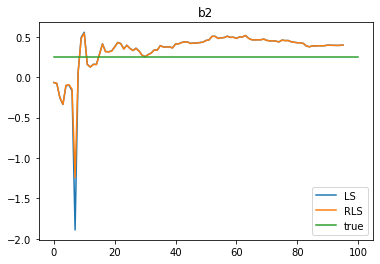

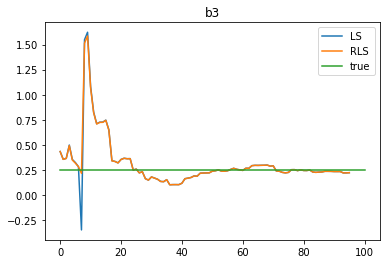

In [22]:
labels = ['a0', 'a1', 'a2', 'a3', 'coef', 'b1', 'b2', 'b3']
true_coef = a + [1] + b
N_iter = LS_history.size
for i in range(2+sum(gen_order)):
    plt.plot(LS_history[:, i], label = 'LS')
    plt.plot(RLS_history[:, i], label = 'RLS')
    plt.plot([0, N], [true_coef[i]]*2, label = 'true')
    plt.title(labels[i])
    plt.legend()
#     plt.savefig(f'./lab_1_pics/{labels[i]}.png', bbox = 'tight', dpi = 300)
    plt.show()